<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$ [R_d_T]: Derivada do torque do robô (variação do torque com o tempo).
- $\tau_{r}$ [R_T]: Torque do robô.
- $S_Fx$ [R_Fx]: Sensor de torque Tx.
- $\omega_{l}$ [R_w_l]: Velocidade da coroa.
- $\theta_{l}$ [R_t_l]: Ângulo da coroa.
- $\omega_{h}$ [R_w_p]: Velocidade da pessoa.
- $\theta_{h}$ [R_t_p]: Ângulo da pessoa.
- $∫e(Interacao).dt$ [R_i_T_e]: Integral do erro de torque.
- $U(x)$ [R_u]: Sinal de controle.
- $\tau^{d}_{r}$ [R_T_d]: Torque desejado do robô.
- $\theta_{m}$ [R_t_m]: Ângulo do motor.
- $\frac{d\omega_{l}}{dt}$ [R_d_w_l]: Derivada da velocidade da coroa (variação da velocidade da coroa com o tempo).
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$ [L_t_m]: Ângulo do motor na perna esquerda.
- $\theta_{l, L}$ [L_t_l]: Ângulo da coroa na perna esquerda.
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$ [L_T_r]: Torque real no lado esquerdo.
- $\tau^{d}_{r, L}$ [L_T_d]: Torque desejado no lado esquerdo.

### Variáveis adicionais (não presentes no dataset mas relevantes no código):
- $\tau_{i}$ [R_T_i]: Torque de interação.

# Bibliotecas

In [1]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [21]:
drive.mount('/content/drive')
t6_markov = "drive/MyDrive/Markov/T6/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t6 = pd.read_table(t6_markov, header=None, names=head_markov, index_col=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


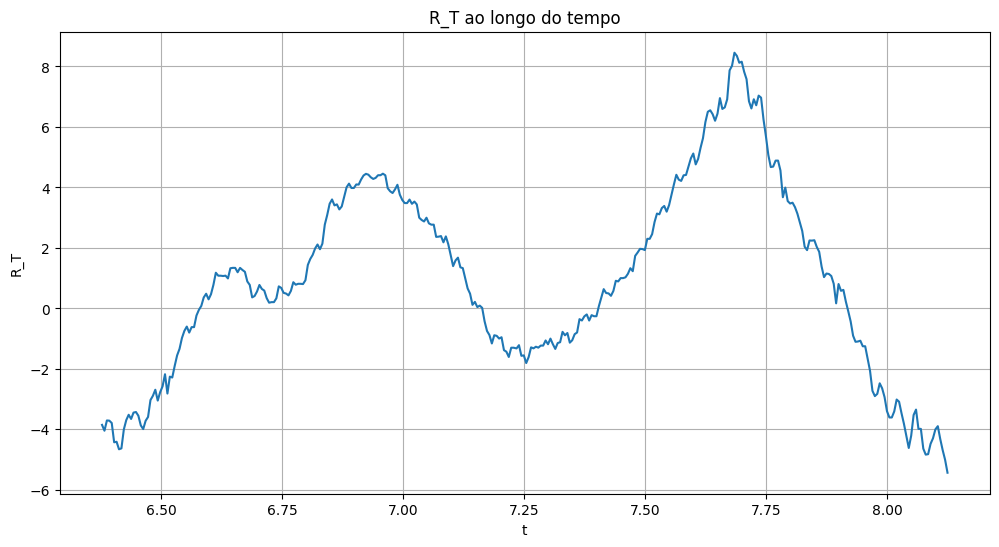

In [35]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t6['t'].iloc[1275:1625], markov_t6['R_T'].iloc[1275:1625])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

In [38]:
data = markov_t6.iloc[1275:]
# Remover linhas onde R_w_l é zero
data = data.loc[data['R_w_l'] != 0]

# 2º Passo: Cálculo (Markov 6, Dados Completos)

In [ ]:
# Ka = 200  # Rigidez do acessório
# Ba = 10   # Amortecimento do acessório
# data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
# data['d_tau_i'] = np.gradient(data['tau_i'])

<ipython-input-6-ada45a1a3584>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
<ipython-input-6-ada45a1a3584>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['d_tau_i'] = np.gradient(data['tau_i'])


# 3º Passo: Separação e Normalização dos dados


In [41]:
dataset = data.copy()
X = dataset[['R_t_p', 'R_t_l', 'R_w_p', 'R_w_l', 'phase']]  # Inputs
y = dataset[['R_T_d']]  # Saída: torque desejado (já calculado pelo sistema)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [42]:
timesteps = 350  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (9143, 350, 5)
Forma dos dados de saída: (9143, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [43]:
model_cnn_lstm = Sequential()

# Ajustar o input_shape para refletir o número de características (4)
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features), padding='causal'))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))

# Camada LSTM com return_sequences para empilhar
model_cnn_lstm.add(LSTM(128, return_sequences=True))
model_cnn_lstm.add(Dropout(0.2))

# Camada LSTM final
model_cnn_lstm.add(LSTM(64, return_sequences=False))
model_cnn_lstm.add(Dropout(0.2))

# Camada de saída (regressão - sem ativação)
model_cnn_lstm.add(Dense(1))

# Compilação para regressão (usando Huber ou MSE)
model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=Huber(),  # Alternativa: 'mse'
    metrics=['MAE', 'MSE']
)

model_cnn_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 350, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 175, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 175, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 175, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,313 (583.25 KB)

 Trainable params: 149,313 (583.25 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [59]:
# Treinamento do modelo
history = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=32,            # Número de épocas ajustável
    batch_size=32,        # Lote para atualização dos pesos
    validation_split=0.4, # Separação para validação
    verbose=1             # Exibição detalhada do progresso
)

Epoch 1/32
172/172 ━━━━━━━━━━━━━━━━━━━━ 90s 523ms/step - MAE: 0.0336 - MSE: 0.0020 - loss: 0.0010 - val_MAE: 0.0607 - val_MSE: 0.0059 - val_loss: 0.0030
Epoch 2/32
172/172 ━━━━━━━━━━━━━━━━━━━━ 145s 539ms/step - MAE: 0.0291 - MSE: 0.0015 - loss: 7.6348e-04 - val_MAE: 0.0541 - val_MSE: 0.0049 - val_loss: 0.0024
Epoch 3/32
172/172 ━━━━━━━━━━━━━━━━━━━━ 140s 526ms/step - MAE: 0.0295 - MSE: 0.0015 - loss: 7.6593e-04 - val_MAE: 0.0604 - val_MSE: 0.0059 - val_loss: 0.0030
Epoch 4/32
172/172 ━━━━━━━━━━━━━━━━━━━━ 136s 490ms/step - MAE: 0.0280 - MSE: 0.0014 - loss: 7.1557e-04 - val_MAE: 0.0553 - val_MSE: 0.0048 - val_loss: 0.0024
Epoch 5/32
172/172 ━━━━━━━━━━━━━━━━━━━━ 150s 537ms/step - MAE: 0.0277 - MSE: 0.0014 - loss: 6.9348e-04 - val_MAE: 0.0547 - val_MSE: 0.0046 - val_loss: 0.0023
Epoch 6/32
172/172 ━━━━━━━━━━━━━━━━━━━━ 140s 529ms/step - MAE: 0.0283 - MSE: 0.0014 - loss: 7.1086e-04 - val_MAE: 0.0600 - val_MSE: 0.0064 - val_loss: 0.0032
Epoch 7/32
172/172 ━━━━━━━━━━━━━━━━━━━━ 91s 530ms/step - 

# 7º Passo: Avaliação e Previsão

In [60]:
y_pred_scaled = model_cnn_lstm.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

286/286 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step
R²: 0.9503178548536776
MAE: 0.2825 Nm
RMSE: 0.4079 Nm


# 8º Passo: Visualização das perdas (train vs validation)

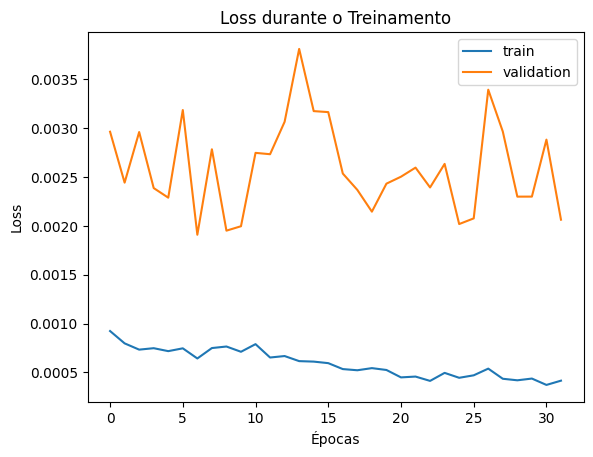

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

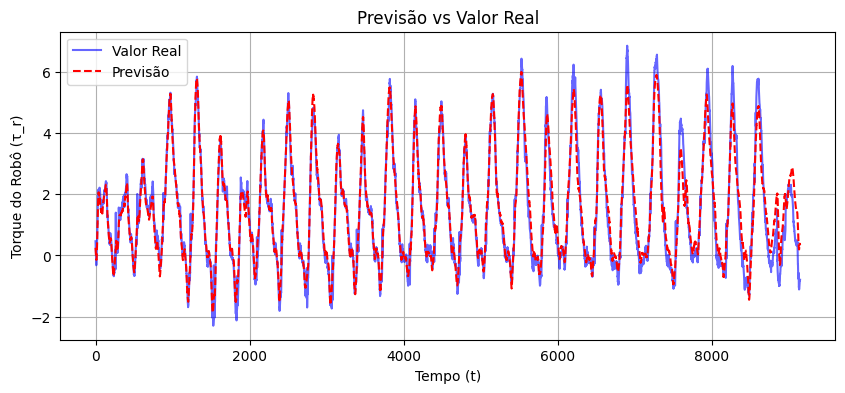

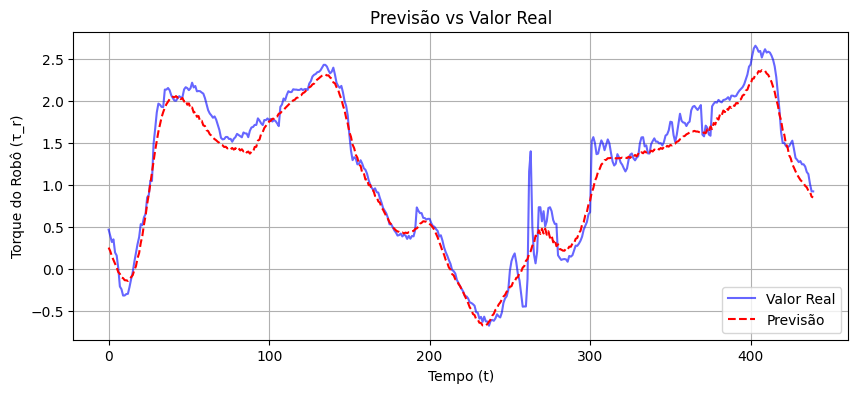

In [62]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[:], y_pred[:])
plot_predictions(y_train_rescaled[:540], y_pred[:540])



# 10º Passo: Erro

In [63]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred.flatten()

#11º Passo: Plot do Erro

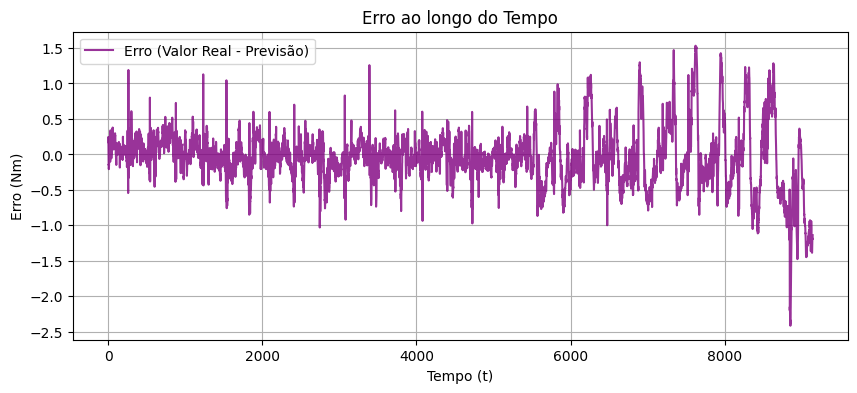

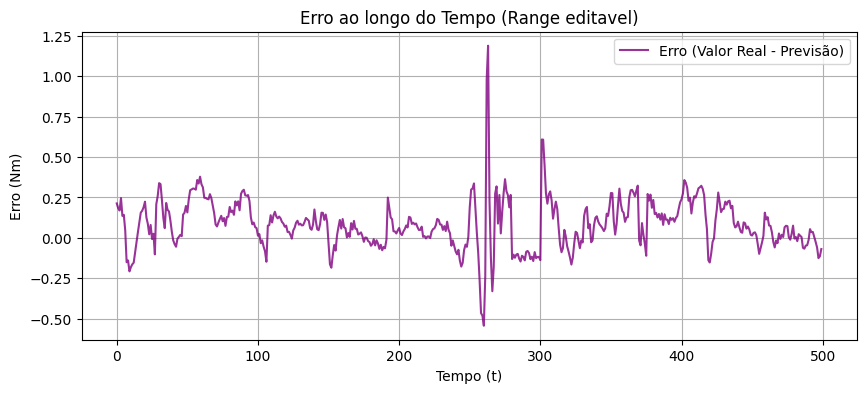

Média do Erro: -0.0462 Nm
Desvio Padrão do Erro: 0.4053 Nm


In [64]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:500], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')

#12º Passo: Validação

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/py


Estatísticas do Torque de Interação:
- τ_i esperado médio: 605935896887.65 Nm
- τ_i previsto médio: -81.23 Nm
- MAE: 80419168526576.9062 Nm
- RMSE: 154810189367422.8438 Nm



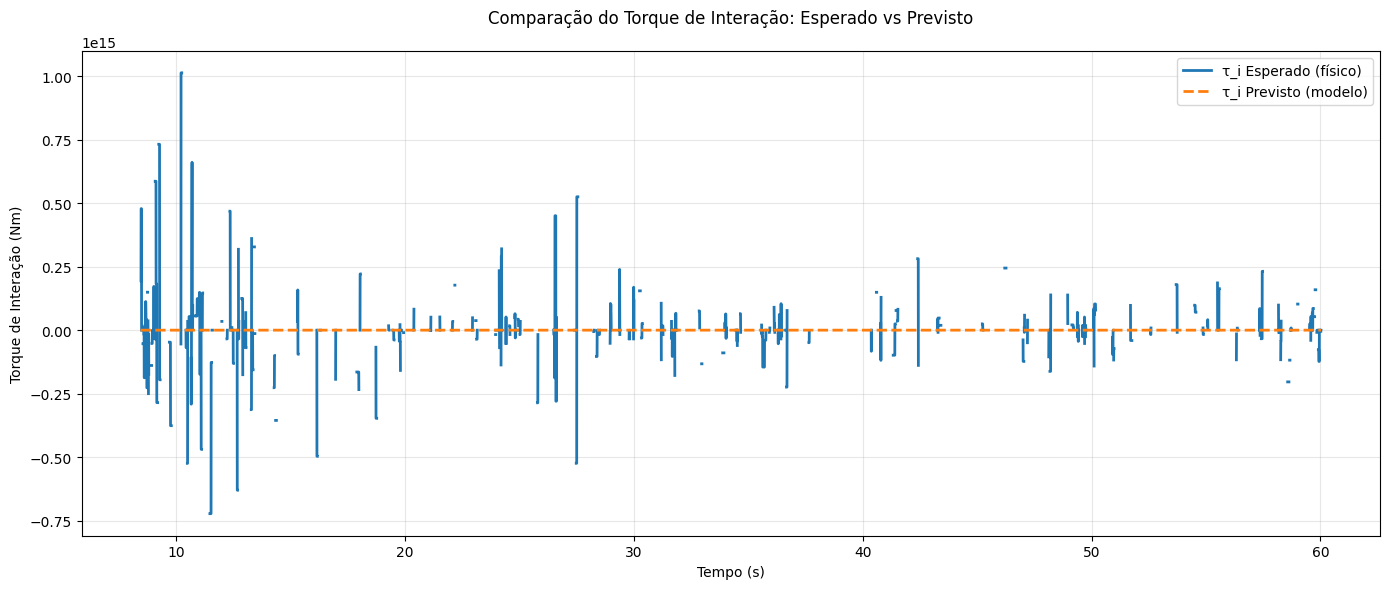

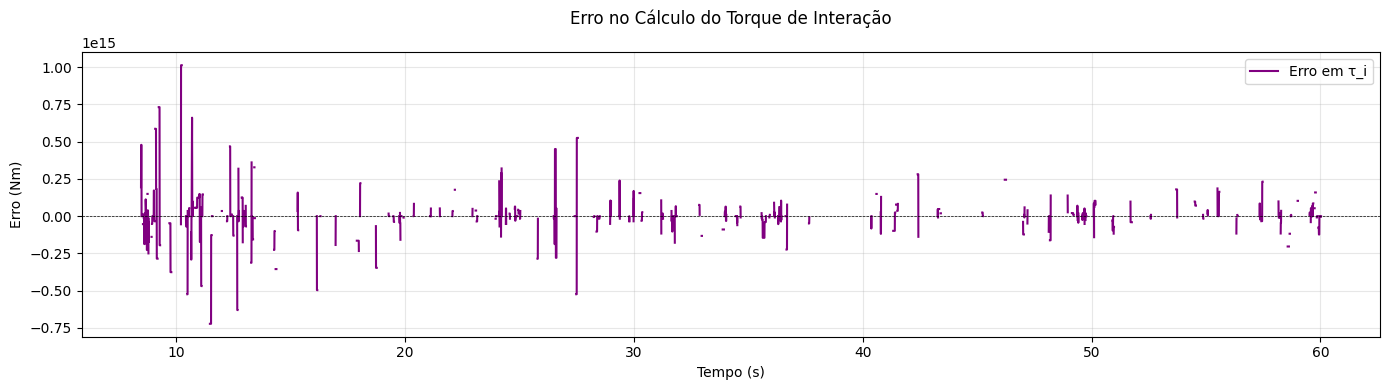

In [94]:
# 12º Passo: Cálculo do Torque de Interação (τ_i) - Versão Corrigida e Completa

# Parâmetros do sistema
Ks = 105      # [Nm/rad] Rigidez do exoesqueleto
Nr = 150      # [] Redução do motor
Ka = 200      # [Nm/rad] Rigidez do acessório
Ba = 10       # [Nms/rad] Amortecimento do acessório
Bh_values = np.array([2, 1.2, 1.2, 4, 1.5])  # Bh por fase

# Criar DataFrame com resultados do modelo
results = pd.DataFrame({
    'Time': data['t'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'Real_R_T': y_train_rescaled.flatten(),
    'Predicted_R_T': y_pred.flatten(),
    'R_t_m': data['R_t_m'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_l': data['R_t_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_p': data['R_t_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_p': data['R_w_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_l': data['R_w_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'phase': data['phase'].iloc[timesteps:timesteps+len(y_train_rescaled)].values
})

# 1. Cálculo das variáveis angulares
results['phi_r'] = results['R_t_l']          # Ângulo da coroa [rad]
results['phi_h'] = results['R_t_p']          # Ângulo humano [rad]
results['phi_m'] = results['R_t_m']          # Ângulo do motor [rad]
results['phi_w'] = results['phi_m'] / Nr     # Ângulo pós-redução [rad]

# 2. Cálculo das derivadas temporais (método robusto)
dt = np.gradient(results['Time'])
results['dphi_r'] = np.gradient(results['phi_r'], dt)  # [rad/s]
results['dphi_h'] = np.gradient(results['phi_h'], dt)  # [rad/s]

# 3. Torque de interação ESPERADO (fórmula física)
results['tau_i_esperado'] = Ka * (results['phi_r'] - results['phi_h']) + Ba * (results['dphi_r'] - results['dphi_h'])

# 4. Torque do robô PREVISTO (a partir do modelo LSTM)
results['tau_r_previsto'] = results['Predicted_R_T']

# 5. Torque de interação PREVISTO (solução numérica implícita)
tau_i_previsto = np.zeros(len(results))
Bh_map = {i: Bh_values[i] for i in range(5)}  # Mapeamento fase → Bh

for i in range(1, len(results)):
    current_phase = int(results['phase'].iloc[i])
    Bh = Bh_map.get(current_phase, 2.0)  # Default 2.0 se fase não mapeada
    dt = results['Time'].iloc[i] - results['Time'].iloc[i-1]

    # Método implícito (Euler backward)
    tau_i_previsto[i] = (tau_i_previsto[i-1] - results['tau_r_previsto'].iloc[i] * dt * Ba) / (1 + (Bh/Ba)*dt)

results['tau_i_previsto'] = tau_i_previsto

# 6. Análise de erros
results['erro_tau_i'] = results['tau_i_esperado'] - results['tau_i_previsto']
print(f'''
Estatísticas do Torque de Interação:
- τ_i esperado médio: {np.mean(results['tau_i_esperado']):.2f} Nm
- τ_i previsto médio: {np.mean(results['tau_i_previsto']):.2f} Nm
- MAE: {np.mean(np.abs(results['erro_tau_i'])):.4f} Nm
- RMSE: {np.sqrt(np.mean(results['erro_tau_i']**2)):.4f} Nm
''')

# 7. Visualização
plt.figure(figsize=(14, 6))
plt.plot(results['Time'], results['tau_i_esperado'], label='τ_i Esperado (físico)', linewidth=2)
plt.plot(results['Time'], results['tau_i_previsto'], label='τ_i Previsto (modelo)', linestyle='--', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Torque de Interação (Nm)')
plt.title('Comparação do Torque de Interação: Esperado vs Previsto', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Visualização do erro
plt.figure(figsize=(14, 4))
plt.plot(results['Time'], results['erro_tau_i'], label='Erro em τ_i', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Erro (Nm)')
plt.title('Erro no Cálculo do Torque de Interação', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#13º Passo: Torque de Interação Real vs Torque de Interação Modelo

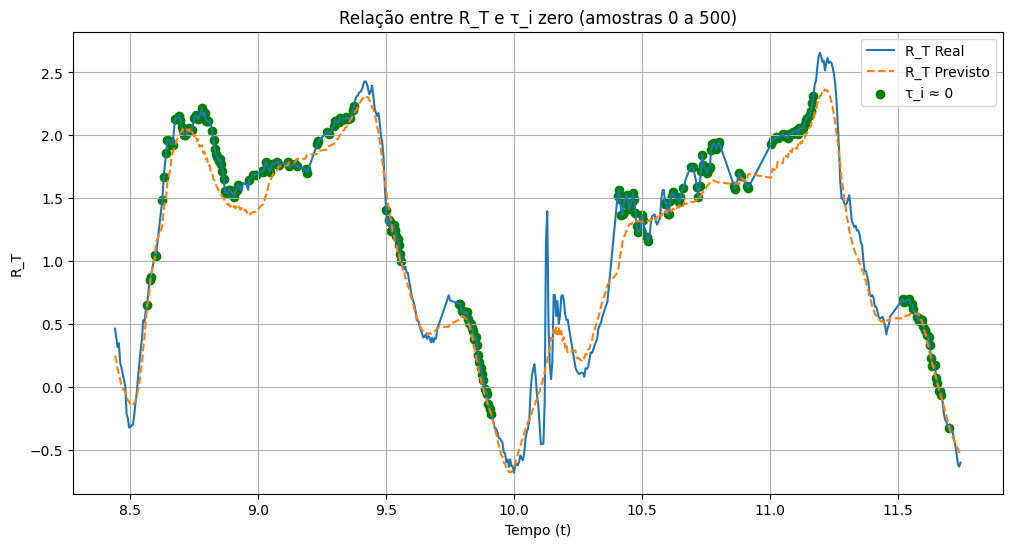

In [93]:
# Análise adicional: Verificar a relação entre R_T previsto e τ_i zero com seleção por intervalos
plt.figure(figsize=(12, 6))

# Definir intervalo personalizado (ex: primeiras 500 amostras)
start_idx = 0
end_idx = 500

# Plot com iloc para seleção de intervalo
plt.plot(results['Time'].iloc[start_idx:end_idx],
         results['Real_R_T'].iloc[start_idx:end_idx],
         label='R_T Real')

plt.plot(results['Time'].iloc[start_idx:end_idx],
         results['Predicted_R_T'].iloc[start_idx:end_idx],
         label='R_T Previsto',
         linestyle='--')

# Filtro para τ_i ≈ 0 no intervalo selecionado
tau_zero_mask = results['tau_i_zero'].iloc[start_idx:end_idx]
plt.scatter(results['Time'].iloc[start_idx:end_idx][tau_zero_mask],
            results['Real_R_T'].iloc[start_idx:end_idx][tau_zero_mask],
            color='green',
            label='τ_i ≈ 0')

plt.title(f'Relação entre R_T e τ_i zero (amostras {start_idx} a {end_idx})')
plt.xlabel('Tempo (t)')
plt.ylabel('R_T')
plt.legend()
plt.grid(True)
plt.show()

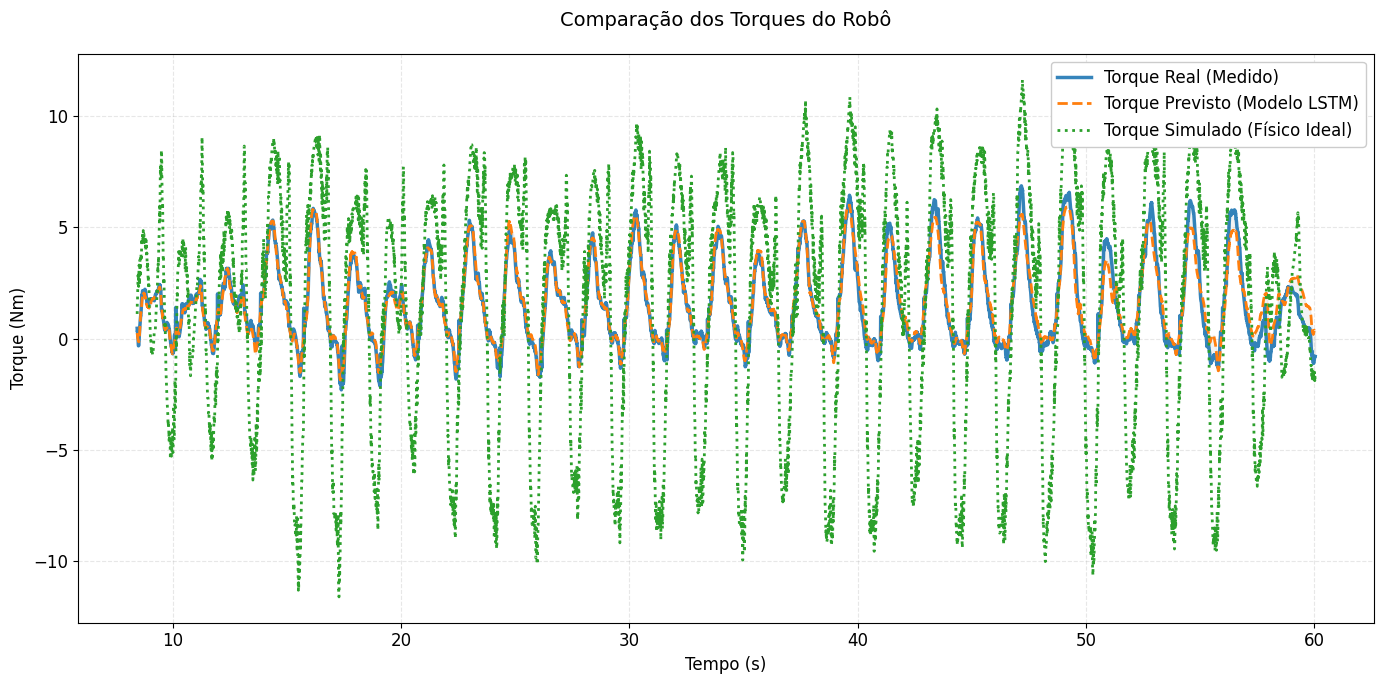


Estatísticas Comparativas:
Métrica                         Real   Previsto   Simulado
-------------------------------------------------------
Média (Nm)                      1.47       1.52       1.55
Desvio Padrão (Nm)              1.83       1.69       5.54
Correlação com Real                -       0.98       0.80


In [95]:
# 12º Passo: Cálculo e Visualização dos Torques Comparativos

# Parâmetros do sistema
Ks = 105      # [Nm/rad] Rigidez do exoesqueleto
Nr = 150      # [] Redução do motor
Ka = 200      # [Nm/rad] Rigidez do acessório
Ba = 10       # [Nms/rad] Amortecimento do acessório
Bh_values = np.array([2, 1.2, 1.2, 4, 1.5])  # Bh por fase

# Criar DataFrame com todos os resultados
results = pd.DataFrame({
    'Time': data['t'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'Real_R_T': y_train_rescaled.flatten(),      # Torque real medido
    'Predicted_R_T': y_pred.flatten(),           # Torque previsto pelo modelo
    'R_t_m': data['R_t_m'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_l': data['R_t_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_p': data['R_t_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_p': data['R_w_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_l': data['R_w_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'phase': data['phase'].iloc[timesteps:timesteps+len(y_train_rescaled)].values
})

# 1. Cálculo do torque do robô SIMULADO (físico ideal)
results['phi_w'] = results['R_t_m'] / Nr  # Ângulo pós-redução
results['tau_r_simulado'] = Ks * (results['phi_w'] - results['R_t_l'])

# 2. Configuração do gráfico
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 12})

# 3. Plot das três curvas de torque
plt.plot(results['Time'], results['Real_R_T'],
         label='Torque Real (Medido)',
         color='#1f77b4', linewidth=2.5, alpha=0.9)

plt.plot(results['Time'], results['Predicted_R_T'],
         label='Torque Previsto (Modelo LSTM)',
         color='#ff7f0e', linestyle='--', linewidth=2)

plt.plot(results['Time'], results['tau_r_simulado'],
         label='Torque Simulado (Físico Ideal)',
         color='#2ca02c', linestyle=':', linewidth=2)

# 4. Configurações do gráfico
plt.title('Comparação dos Torques do Robô', pad=20, fontsize=14)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Torque (Nm)', fontsize=12)
plt.legend(loc='upper right', framealpha=1)
plt.grid(True, linestyle='--', alpha=0.3)

# 5. Limites do eixo y (ajuste conforme seus dados)
ymin = min(results['Real_R_T'].min(), results['Predicted_R_T'].min(), results['tau_r_simulado'].min()) * 1.1
ymax = max(results['Real_R_T'].max(), results['Predicted_R_T'].max(), results['tau_r_simulado'].max()) * 1.1
plt.ylim(ymin, ymax)

# 6. Destaque para áreas importantes (opcional)
plt.fill_between(results['Time'], results['Real_R_T'], results['Predicted_R_T'],
                 color='gray', alpha=0.1, label='Diferença Real-Previsto')

plt.tight_layout()
plt.show()

# 7. Estatísticas comparativas
print('\nEstatísticas Comparativas:')
print(f"{'Métrica':<25} {'Real':>10} {'Previsto':>10} {'Simulado':>10}")
print(f"{'-'*55}")
print(f"{'Média (Nm)':<25} {np.mean(results['Real_R_T']):>10.2f} {np.mean(results['Predicted_R_T']):>10.2f} {np.mean(results['tau_r_simulado']):>10.2f}")
print(f"{'Desvio Padrão (Nm)':<25} {np.std(results['Real_R_T']):>10.2f} {np.std(results['Predicted_R_T']):>10.2f} {np.std(results['tau_r_simulado']):>10.2f}")
print(f"{'Correlação com Real':<25} {'-':>10} {np.corrcoef(results['Real_R_T'], results['Predicted_R_T'])[0,1]:>10.2f} {np.corrcoef(results['Real_R_T'], results['tau_r_simulado'])[0,1]:>10.2f}")